In [1]:
import sys
import os.path as op
from glob import glob
import shutil
import warnings
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import nibabel as nib

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

sys.path.append(op.join(op.expanduser("~"), "code/style"))
from colors import get_colors
co, palettes = get_colors()

sys.path.append(op.join(op.expanduser("~"), "code"))
from general.array import array_operations as aop
from general.basic.helper_funcs import *
from general.basic.str_methods import *
import general.nifti.nifti_ops as nops
import general.nifti.nifti_plotting as niiplot
colors = [
    "2E45B8",
    "3EBCD2",
    "FF4983",
    "1DC9A4",
    "F9C31F",
    "B38FE7",
    "F97A1F",
    "E3120B",
]
font = {"tick": 10, "label": 12, "title": 14, "annot": 12}
pad = {"tick": 2, "label": 5, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 7.28346}
lws = {"axis": 0.8, "line": 1.5, "marker": 0.8}

%matplotlib inline
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.grid.which"] = "both"
mpl.rcParams["axes.labelpad"] = pad["label"]
mpl.rcParams["axes.labelsize"] = font["label"]
mpl.rcParams["axes.linewidth"] = lws["axis"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.titlepad"] = pad["title"]
mpl.rcParams["axes.titlesize"] = font["title"]
mpl.rcParams["figure.autolayout"] = True
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (colws[3], colws[3]*0.618034)
mpl.rcParams["figure.labelsize"] = font["label"]
mpl.rcParams["figure.subplot.hspace"] = 0.2
mpl.rcParams["figure.subplot.wspace"] = 0.2
mpl.rcParams["figure.titlesize"] = font["title"]
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.serif'] = "Times New Roman"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["grid.color"] = "#B7C6CF"
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["hist.bins"] = 30
mpl.rcParams["legend.borderaxespad"] = 0
mpl.rcParams["legend.fontsize"] = font["tick"]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.handletextpad"] = 0.4
mpl.rcParams["legend.markerscale"] = 1
mpl.rcParams["legend.title_fontsize"] = font["label"]
mpl.rcParams["lines.color"] = colors[0]
mpl.rcParams["lines.linewidth"] = lws["line"]
mpl.rcParams["lines.markeredgewidth"]: lws["marker"]
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["patch.facecolor"] = colors[1]
mpl.rcParams["patch.linewidth"] = lws["marker"]
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["savefig.directory"] = "~/Downloads"
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["savefig.pad_inches"] = 0.05
mpl.rcParams["xtick.labelsize"] = font["tick"]
mpl.rcParams["xtick.major.size"] = 4
mpl.rcParams["xtick.major.width"] = lws["axis"]
mpl.rcParams["xtick.minor.ndivs"] = 2
mpl.rcParams["ytick.labelsize"] = font["tick"]
mpl.rcParams["ytick.major.size"] = 4
mpl.rcParams["ytick.major.width"] = lws["axis"]
mpl.rcParams["ytick.minor.ndivs"] = 2


In [21]:
proj_dir = op.join(op.expanduser("~"), "Box", "CVLT_analyses_Chinese")

# Encode item order
ITEMS = {
    "hat": 1,
    "strawberry": 2,
    "ferry": 3,
    "sweater": 4,
    "pineapple": 5,
    "train": 6,
    "belt": 7,
    "star fruit": 8,
    "plane": 9,
}

# Find all the CVLT files
cvlt_files = glob(
    op.join(proj_dir, "data_capture", "final_data_entry", "*", "*.xlsx"), recursive=True
)

# Load the demographics spreadsheet
demo = pd.read_excel(op.join(proj_dir, "Patient demographics_10-17-2023.xlsx"))

print(f"Found {len(cvlt_files)} CVLT files")
print(f"demo: {demo.shape}")


Found 131 CVLT files
demo: (131, 16)


In [233]:
class cvltFormatter(object):
    """Format data for a CVLT exam."""

    def __init__(self, cvlt_file):
        self.ITEMS = {
            "hat": 1,
            "strawberry": 2,
            "ferry": 3,
            "sweater": 4,
            "pineapple": 5,
            "train": 6,
            "belt": 7,
            "star fruit": 8,
            "plane": 9,
        }
        self.COLUMNS = [
            "subj",
            "language",
            "task",
            "trial",
            "field",
            "item",
            "study_pos",
            "rec",
            "rec_pos",
        ]
        self.cvlt_file = cvlt_file
        self.cvlt = self.load_cvlt()
        self.free_rec = self.format_free_rec()
        self.free_intr = self.format_free_rec_intr_rep()
        self.cued_rec = self.format_cued_rec()
        self.cued_intr = self.format_cued_rec_intr_rep()
        self.recog = self.format_recog()
        self.false_recog = self.format_false_recog()
        self.data = self.combine_dfs()

    def load_cvlt(self):
        """Load and format Excel CVLT file as a pandas DataFrame."""
        cvlt = pd.read_excel(self.cvlt_file)

        # Format column names
        cvlt = cvlt.rename(columns={cvlt.columns[0]: "item"})
        cvlt.columns = cvlt.columns.str.lower()

        # Get subject-level info
        subj = int(op.basename(self.cvlt_file).split("_")[0])
        language = op.dirname(self.cvlt_file).split("/")[-1].lower()
        cvlt.insert(0, "subj", subj)
        cvlt.insert(1, "language", language)

        return cvlt

    def format_free_rec(self):
        free_rec = pd.melt(
            self.cvlt.iloc[:9, :9],
            id_vars=["subj", "language", "item"],
            var_name="trial",
            value_name="rec_pos",
        )
        free_rec["task"] = "free_recall"
        free_rec["field"] = "study_item"
        free_rec["study_pos"] = free_rec["item"].map(self.ITEMS)
        free_rec["rec"] = free_rec["rec_pos"].apply(lambda x: 1 if x != "nr" else 0)
        free_rec.loc[free_rec["rec_pos"] == "nr", "rec_pos"] = "na"
        free_rec = free_rec[self.COLUMNS]

        return free_rec

    def format_free_rec_intr_rep(self):
        free_intr = pd.melt(
            self.cvlt.iloc[11:21, :9],
            id_vars=["subj", "language", "item"],
            var_name="trial",
            value_name="value",
        ).dropna()
        if free_intr.shape[0] == 0:
            return pd.DataFrame(columns=self.COLUMNS)
        free_intr["task"] = "free_recall"
        free_intr["item"] = free_intr["value"].apply(lambda x: x.split("_")[1])
        free_intr["study_pos"] = free_intr["item"].apply(
            lambda x: ITEMS[x] if x in ITEMS else "na"
        )
        free_intr["field"] = ""
        free_intr.loc[free_intr["study_pos"] == "na", "field"] = "intrusion"
        free_intr.loc[free_intr["study_pos"] != "na", "field"] = "repetition"
        free_intr["rec"] = 1
        free_intr["rec_pos"] = free_intr["value"].apply(lambda x: int(x.split("_")[0]))
        free_intr = free_intr[self.COLUMNS]

        return free_intr

    def format_cued_rec(self):
        cued_rec = pd.melt(
            pd.concat((self.cvlt.iloc[:9, :3], self.cvlt.iloc[:9, 9:12]), axis=1),
            id_vars=["subj", "language", "item"],
            var_name="trial",
            value_name="rec_pos",
        )
        cued_rec = cued_rec.query("(rec_pos!='na')").reset_index(drop=True)
        cued_rec["task"] = "cued_recall"
        cued_rec["field"] = "study_item"
        cued_rec["study_pos"] = cued_rec["item"].map(self.ITEMS)
        cued_rec["rec"] = cued_rec["rec_pos"].apply(lambda x: 1 if x != "nr" else 0)
        cued_rec.loc[cued_rec["rec_pos"] == "nr", "rec_pos"] = "na"
        cued_rec = cued_rec[self.COLUMNS]

        return cued_rec

    def format_cued_rec_intr_rep(self):
        cued_intr = pd.melt(
            pd.concat((self.cvlt.iloc[11:21, :3], self.cvlt.iloc[11:21, 9:12]), axis=1),
            id_vars=["subj", "language", "item"],
            var_name="trial",
            value_name="value",
        ).dropna()
        if cued_intr.shape[0] == 0:
            return pd.DataFrame(columns=self.COLUMNS)
        cued_intr["task"] = "cued_recall"
        cued_intr["item"] = cued_intr["value"].apply(lambda x: x.split("_")[1])
        cued_intr["study_pos"] = cued_intr["item"].apply(
            lambda x: ITEMS[x] if x in ITEMS else "na"
        )
        cued_intr["field"] = ""
        cued_intr.loc[cued_intr["study_pos"] == "na", "field"] = "intrusion"
        cued_intr.loc[cued_intr["study_pos"] != "na", "field"] = "repetition"
        cued_intr["rec"] = 1
        cued_intr["rec_pos"] = cued_intr["value"].apply(lambda x: int(x.split("_")[0]))
        cued_intr = cued_intr[self.COLUMNS]

        return cued_intr

    def format_recog(self):
        recog = pd.concat((self.cvlt.iloc[:9, :3], self.cvlt.iloc[:9, 12]), axis=1)
        recog["task"] = "recognition"
        recog["trial"] = "recog"
        recog["field"] = "study_item"
        recog["study_pos"] = recog["item"].map(self.ITEMS)
        recog["rec"] = recog["recog"].apply(lambda x: 1 if x == 1 else 0)
        recog["rec_pos"] = "na"
        recog = recog[self.COLUMNS]

        return recog

    def format_false_recog(self):
        row_idx = np.arange(9).tolist() + np.arange(11, 20).tolist()
        false_recog = pd.concat(
            (self.cvlt.iloc[row_idx, :2], self.cvlt.iloc[row_idx, 13:]), axis=1
        ).reset_index(drop=True)
        false_recog["task"] = "recognition"
        false_recog["trial"] = "recog"
        false_recog["field"] = "related_intrusion"
        false_recog.loc[9:, "field"] = "unrelated_intrusion"
        false_recog["item"] = false_recog["distractors"]
        false_recog["study_pos"] = "na"
        false_recog["rec"] = false_recog["false _rec"].apply(
            lambda x: 1 if x == 1 else 0
        )
        false_recog["rec_pos"] = "na"
        false_recog = false_recog[self.COLUMNS]

        return false_recog

    def combine_dfs(self):
        data = pd.concat(
            (
                self.free_rec,
                self.free_intr,
                self.cued_rec,
                self.cued_intr,
                self.recog,
                self.false_recog,
            ),
            axis=0,
        )
        # Make data["task"] an ordered categorical variable
        data["task"] = data["task"].astype(
            pd.CategoricalDtype(
                categories=["free_recall", "cued_recall", "recognition"], ordered=True
            )
        )
        data["trial"] = data["trial"].astype(
            pd.CategoricalDtype(
                categories=[
                    "trial1",
                    "trial2",
                    "trial3",
                    "trial4",
                    "brief_delay",
                    "10min_delay",
                    "cued_fruit",
                    "cued_clothing",
                    "cued_vehicles",
                    "recog",
                ],
                ordered=True,
            )
        )
        data["field"] = data["field"].astype(
            pd.CategoricalDtype(
                categories=[
                    "study_item",
                    "repetition",
                    "intrusion",
                    "related_intrusion",
                    "unrelated_intrusion",
                ],
                ordered=True,
            )
        )
        data = data.sort_values(["task", "trial", "study_pos"]).reset_index(drop=True)

        return data


In [237]:
save_output = True
overwrite = False

cvlt_dat = (
    pd.concat([cvltFormatter(f).data for f in cvlt_files], axis=0)
    .sort_values(["subj", "task", "trial", "study_pos"])
    .reset_index(drop=True)
)

# Save the output
if save_output:
    outfile = op.join(
        proj_dir,
        "cvlt-responses-formatted_{}-subjects_{}.csv".format(
            cvlt_dat.subj.nunique(), today()
        ),
    )
    if overwrite or not op.exists(outfile):
        cvlt_dat.to_csv(outfile, index=False)
        print(f"Saved {outfile}")

print(f"cvlt_dat: {cvlt_dat.shape[0]} rows for {cvlt_dat.subj.nunique()} subjects")


Saved /Users/dschonhaut/Box/CVLT_analyses_Chinese/cvlt-responses-formatted_131-subjects_2023-11-20.csv
cvlt_dat: 12170 rows for 131 subjects


/var/folders/lq/rtbxthxd0ld0kkzmrlfbcktc0000gp/T/ipykernel_9452/1513248664.py:26: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


Text(0, 0.5, 'Recall probability')

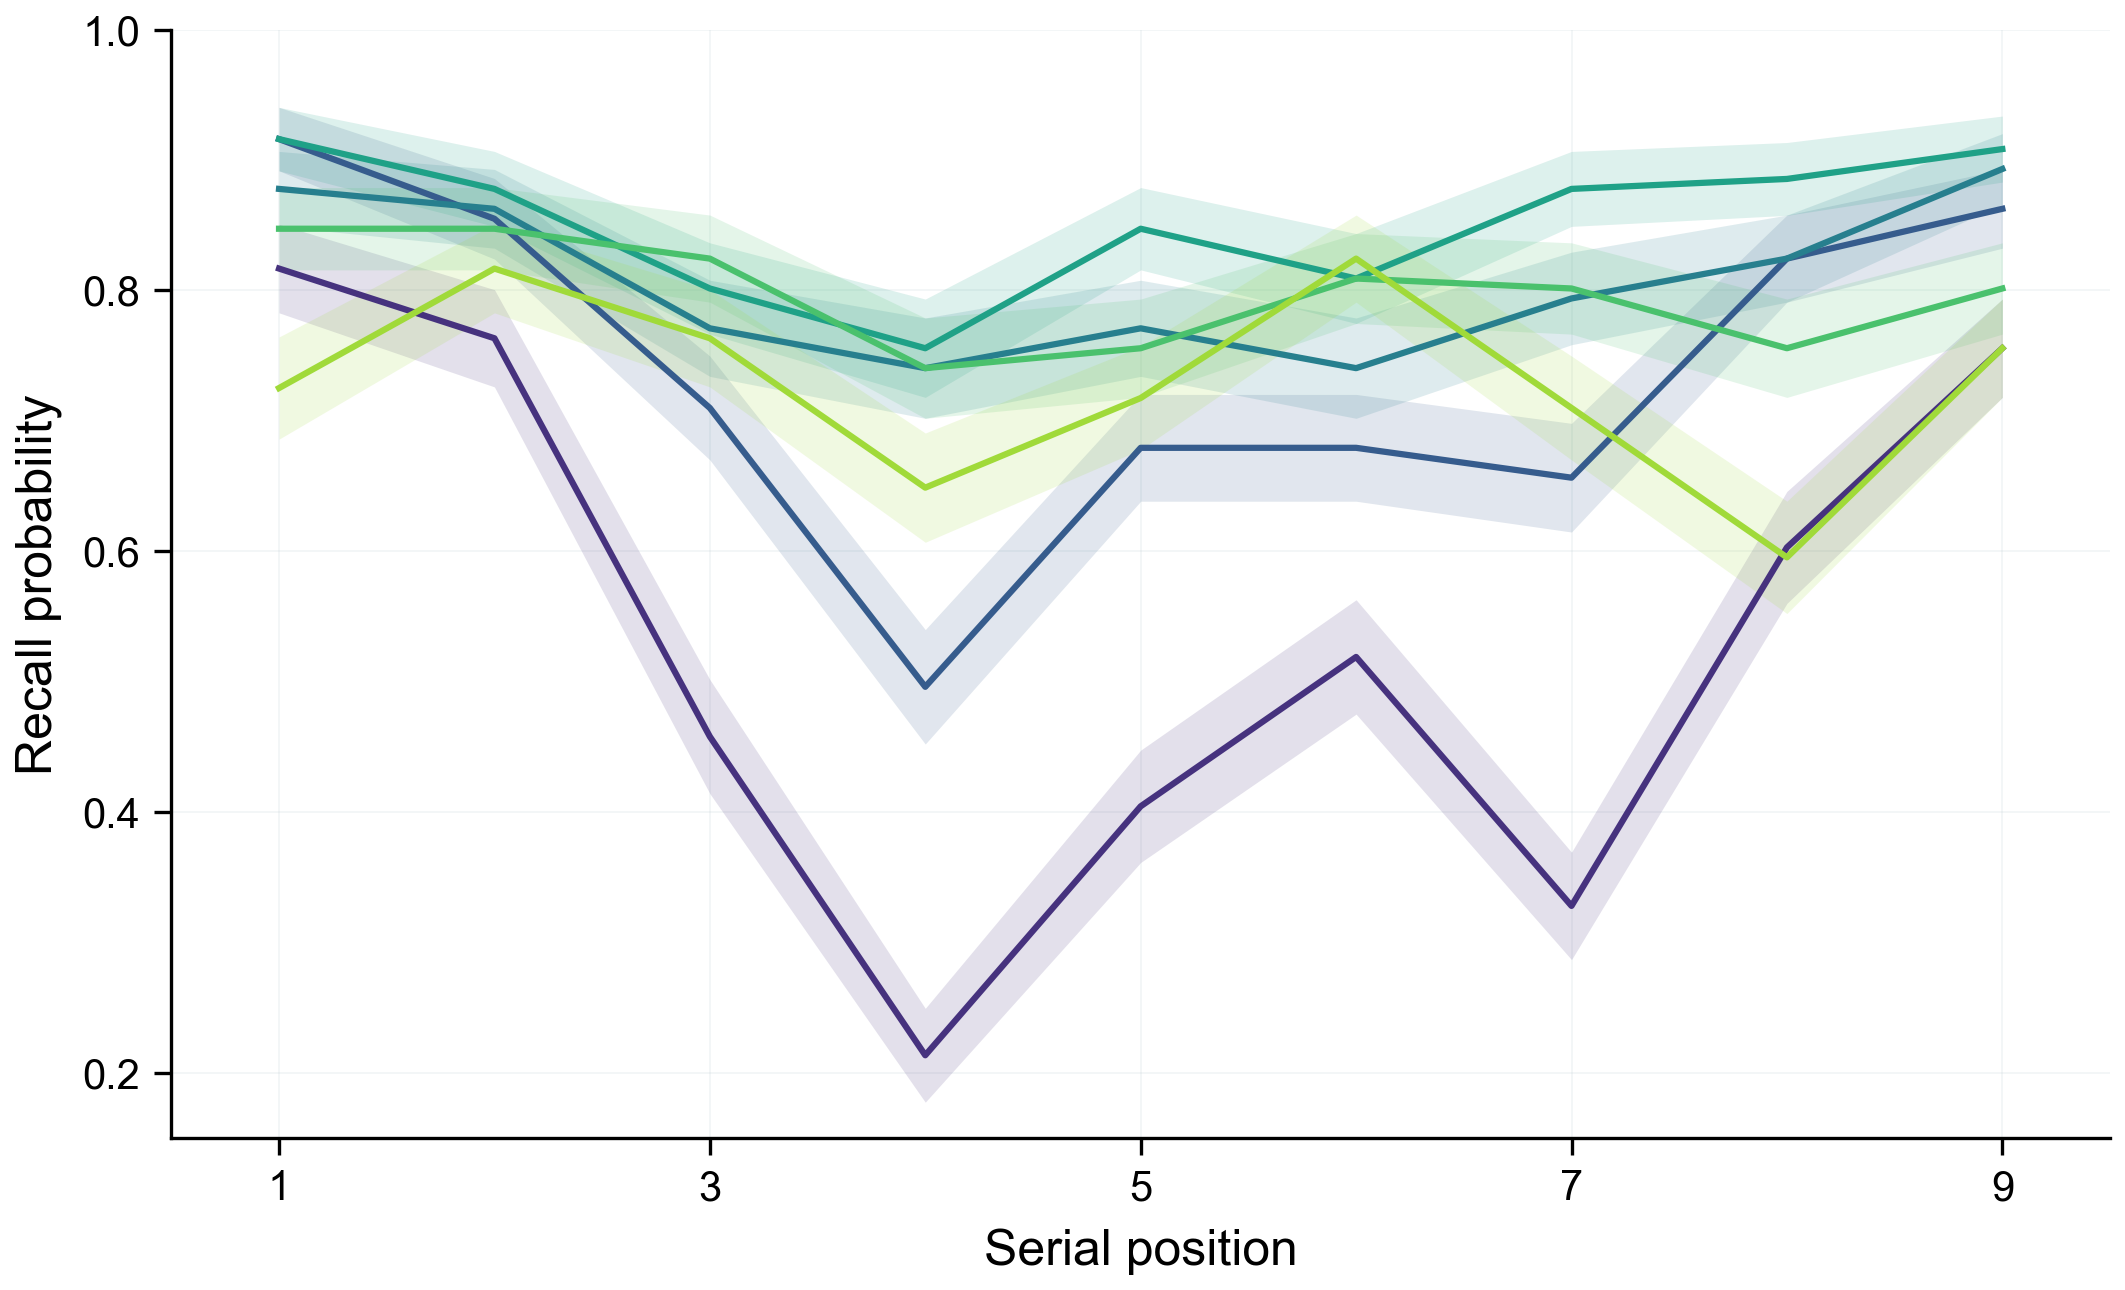

In [263]:
trials = ["trial1", "trial2", "trial3", "trial4", "brief_delay", "10min_delay"]
palette = sns.color_palette("viridis", len(trials))

means = (
    cvlt_dat.query(
        "(task=='free_recall') & (trial=={}) & (field=='study_item')".format(trials)
    )
    .groupby(["trial", "study_pos"])
    .rec.mean()
    .dropna()
    .reset_index()
)

sems = (
    cvlt_dat.query(
        "(task=='free_recall') & (trial=={}) & (field=='study_item')".format(trials)
    )
    .groupby(["trial", "study_pos"])
    .rec.sem()
    .dropna()
    .reset_index()
)

# Plot
fig, ax = plt.subplots(figsize=(colws[3], colws[3] * 0.618034))
sns.lineplot(
    x="study_pos",
    y="rec",
    hue="trial",
    data=means,
    ax=ax,
    palette=palette,
    lw=lws["line"],
    err_style="bars",
    err_kws={"capsize": 1.5, "elinewidth": lws["line"]},
    legend=False,
)
for i, trial in enumerate(trials):
    ax.fill_between(
        means.query(f"(trial=='{trial}')").study_pos,
        means.query(f"(trial=='{trial}')").rec + sems.query(f"(trial=='{trial}')").rec,
        means.query(f"(trial=='{trial}')").rec - sems.query(f"(trial=='{trial}')").rec,
        color=palette[i],
        alpha=0.15,
        lw=0,
    )
ax.set_xlim([0.5, 9.5])
ax.set_xticks(np.arange(1, 10, 2))
ax.set_xlabel("Serial position")
ax.set_ylim([0.15, 1])
ax.set_yticks(np.arange(0.2, 1.1, 0.2))
ax.set_ylabel("Recall probability")
